# Transfer learning with tensorflow part 3: scaling up( 🍔 👀 Food vision mini)

we've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in FOod101 (101 total classes of food).


our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning). 

our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# check to see if we're using a GPU
!nvidia-smi

Tue Feb  7 11:10:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions

in previous notebooks, we've created a series of helper functions to do different tasks , lets doenload them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-07 11:10:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-07 11:10:49 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import series of heper functions for notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: woeking with less data

our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

the data we've downloaded comes from the original Food101 dataset but has been preprocessed using the imaage_data_modification

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-02-07 11:10:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.7MB/s    in 72s     

2023-02-07 11:12:06 (21.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
# how many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 image

In [7]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)#don't shuffle test data for data analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog modle with transfer learning on 10% of 101 food classes

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Built a headless(no top layers) Functional EfficientNetB0 backboned-model (we'll create  our own output layer)
* Compile our model 
* Feature extract for full passes ( 5 epochs on the train dataset and validat on 15% of the test data, to save epochs epoch time) 

In [8]:
#  Create checkpoint callback 
checkpoint_path = "101_classes_10_precent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weight_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras  import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentaion
data_augmentaion = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaleing(1/255.) # rescale inputs of images to between 0 & 1 requirese for model like Resnet
], name="data_augmentation")

In [10]:
# setup the bais model and freeze it layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentaion(inputs) # augment images ( only happens during training phase)
x = base_model(x, training=False) # put the base model in interence mode so weightt which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [11]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs tp keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate only 15% of tst data during training 
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3744 - accuracy: 0.2772

237/237 [==============================] - 137s 521ms/step - loss: 3.3744 - accuracy: 0.2772 - val_loss: 2.4818 - val_accuracy: 0.4640
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1981 - accuracy: 0.4945

237/237 [==============================] - 110s 462ms/step - loss: 2.1981 - accuracy: 0.4945 - val_loss: 2.0412 - val_accuracy: 0.5130
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8381 - accuracy: 0.5624

237/237 [==============================] - 104s 439ms/step - loss: 1.8381 - accuracy: 0.5624 - val_loss: 1.8697 - val_accuracy: 0.5252
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6029 - accuracy: 0.6099

237/237 [==============================] - 99s 415ms/step - loss: 1.6029 - accuracy: 0.6099 - val_loss: 1.8075 - val_accuracy: 0.5344
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4607 - accuracy: 0.6395

237/237 [==============================] - 97s 408ms/step - loss: 1.4607 - accuracy: 0.6395 - val_loss: 1.7618 - val_accuracy: 0.5477


In [13]:
# evaluate on the whole test dataset
fine_tuning_result = model.evaluate(test_data)
fine_tuning_result

790/790 [==============================] - 63s 79ms/step - loss: 1.5960 - accuracy: 0.5796


[1.5960471630096436, 0.5796435475349426]

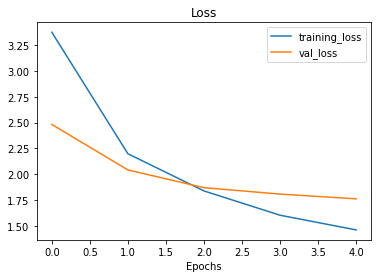

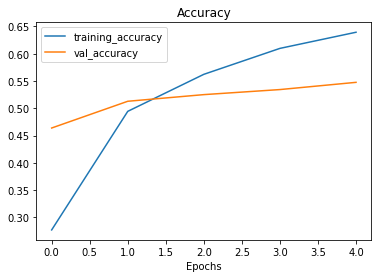

In [14]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** what do these curves suggest ? Hint:
ideally, the two curves should be very similar to each other ,
if not  it may suggest that our model is overfitting (performing too well on the training data and not generalizing to un seen data)

In [15]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),# learning rate lowerd by 10x
              metrics = ["accuracy"])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# what layer in model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# check which layers are trainable i  our model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name ,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
# fine tuning for 5 more epochs 
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 238ms/step - loss: 1.2173 - accuracy: 0.6787 - val_loss: 1.6778 - val_accuracy: 0.5553
Epoch 6/10
237/237 [==============================] - 52s 218ms/step - loss: 1.0848 - accuracy: 0.7110 - val_loss: 1.6631 - val_accuracy: 0.5614
Epoch 7/10
237/237 [==============================] - 51s 213ms/step - loss: 1.0142 - accuracy: 0.7262 - val_loss: 1.6999 - val_accuracy: 0.5530
Epoch 8/10
237/237 [==============================] - 49s 203ms/step - loss: 0.9432 - accuracy: 0.7469 - val_loss: 1.6649 - val_accuracy: 0.5662
Epoch 9/10
237/237 [==============================] - 49s 205ms/step - loss: 0.8884 - accuracy: 0.7625 - val_loss: 1.6741 - val_accuracy: 0.5617
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.8342 - accuracy: 0.7724 - val_loss: 1.6631 - val_accuracy: 0.5646


In [20]:
# Evaluate on the whole test dataset(
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results 

790/790 [==============================] - 61s 77ms/step - loss: 1.5048 - accuracy: 0.6027


[1.50477933883667, 0.602653443813324]

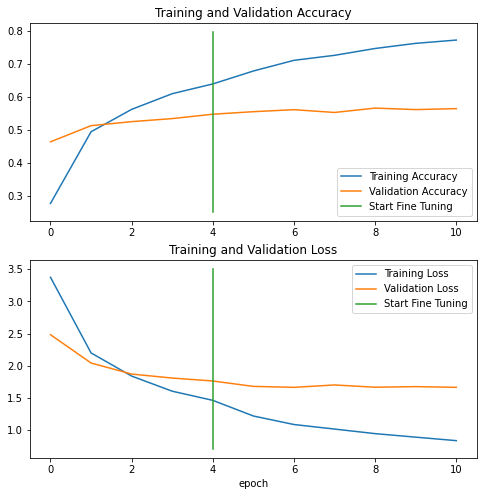

In [21]:
# compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and eport it somewhere.

In [22]:
# save our fine-tuning model
model.save("/content/drive/MyDrive/E:/101_food_classes_10_percent_saved_big_dog_model")

In [23]:
# laod an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/E:/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
#evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results


790/790 [==============================] - 65s 79ms/step - loss: 1.5048 - accuracy: 0.6027


[1.50477933883667, 0.602653443813324]

In [25]:
all_classes_10_percent_fine_tune_results

[1.50477933883667, 0.602653443813324]

## Evaluating the performance of the big dog across all different classes
Let's make some prediction , visualize them and then later find out which prediction were the "most" wrong.

In [26]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
 

--2023-02-07 11:32:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  15.3MB/s    in 2.9s    

2023-02-07 11:32:13 (15.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [28]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model (the one we just downloaded on test data
results_downladed_model = model.evaluate(test_data)

790/790 [==============================] - 63s 78ms/step - loss: 1.8027 - accuracy: 0.6078


In [30]:
results_downladed_model

[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [31]:
# make prediction with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is lefts

790/790 [==============================] - 65s 80ms/step


In [32]:
len(test_data)

790

In [33]:
#how many predictions are there?
len(preds_probs)

25250

In [34]:
# whats the sahpe of our prediction ?
preds_probs.shape

(25250, 101)

In [35]:
# lets see what the first 10 prediction look like 
preds_probs[:10]

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [4.7313261e-01, 1.2931234e-07, 1.4805571e-03, ..., 5.9750129e-04,
        6.6969093e-05, 2.3469318e-05],
       [4.4571854e-02, 4.7265522e-07, 1.2258522e-01, ..., 6.3498674e-06,
        7.5318649e-06, 3.6778811e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2310996e-05, ..., 1.2291390e-03,
        1.5792685e-09, 9.6395743e-05]], dtype=float32)

In [36]:
# whats does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]) , sum(preds_probs[0])

(array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
        8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
        1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
        2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
        6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
        1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
        8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
        2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
        1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
        1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
        8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
        2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
        3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
        8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
        3.5306264e-05, 3.2489010e-05, 6.7314875e

our model output a prediction probability array (with N number of variables, where N is the number of classes ) for each sample passes to the predict method

In [37]:
# we get one prediction probability per class (in our case there's 101 prediction probabilities) 
print(f"Number of prediction probabilities for sample 0:{len(preds_probs)}")
print(f"what prediction probability sample 0 look like :\n {preds_probs}")
print(f"the class with the heighest predicted probability by the model for sample 0 :{preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0:25250
what prediction probability sample 0 look like :
 [[5.9542041e-02 3.5742053e-06 4.1376803e-02 ... 1.4138708e-09
  8.3530598e-05 3.0897530e-03]
 [9.6401680e-01 1.3753194e-09 8.4780209e-04 ... 5.4286946e-05
  7.8361918e-12 9.8465647e-10]
 [9.5925879e-01 3.2533717e-05 1.4866921e-03 ... 7.1891350e-07
  5.4397532e-07 4.0276082e-05]
 ...
 [1.5138779e-05 4.0973077e-04 8.0250906e-10 ... 2.1742910e-05
  1.0797232e-05 5.3789955e-01]
 [5.9318207e-03 4.9236543e-03 9.9823344e-03 ... 1.1989499e-04
  1.6890328e-05 4.5218006e-02]
 [3.1363461e-02 7.5052152e-03 4.2975016e-04 ... 5.0346350e-04
  5.2055889e-06 6.9062936e-01]]
the class with the heighest predicted probability by the model for sample 0 :52


In [38]:
test_data.class_names[52]

'gyoza'

In [39]:
pred_classes = preds_probs.argmax(axis=1)
# how do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [40]:
# how many pred classes do we have
len(pred_classes)

25250

now we've got a predictions array of all of our models prediction , to evaluate them , we need to compare them to the original test dataset labels.

In [41]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())# currently test labels look like : [0,0,0,1,...,0,0], we want the index value

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
# how many y_labels are there?
len(y_labels)

25250

In [43]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Evaluating our model's prediction
one way to check that our model's predictions array is the same order as our test labels array is to find the accuracy score

In [44]:
results_downladed_model

[1.8027206659317017, 0.6077623963356018]

In [45]:
# lets try  scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [46]:
# does this metrics come close to our models evaluate resulte
import numpy as np
np.isclose(results_downladed_model[1], sklearn_accuracy)

True

## let's get visual :making a confusion matrix

In [47]:
from helper_functions import make_confusion_matrix

In [48]:
# get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

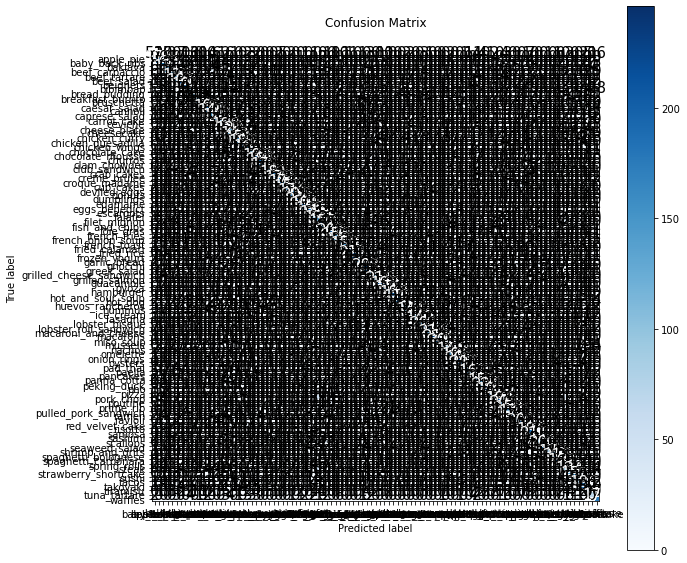

In [49]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names)

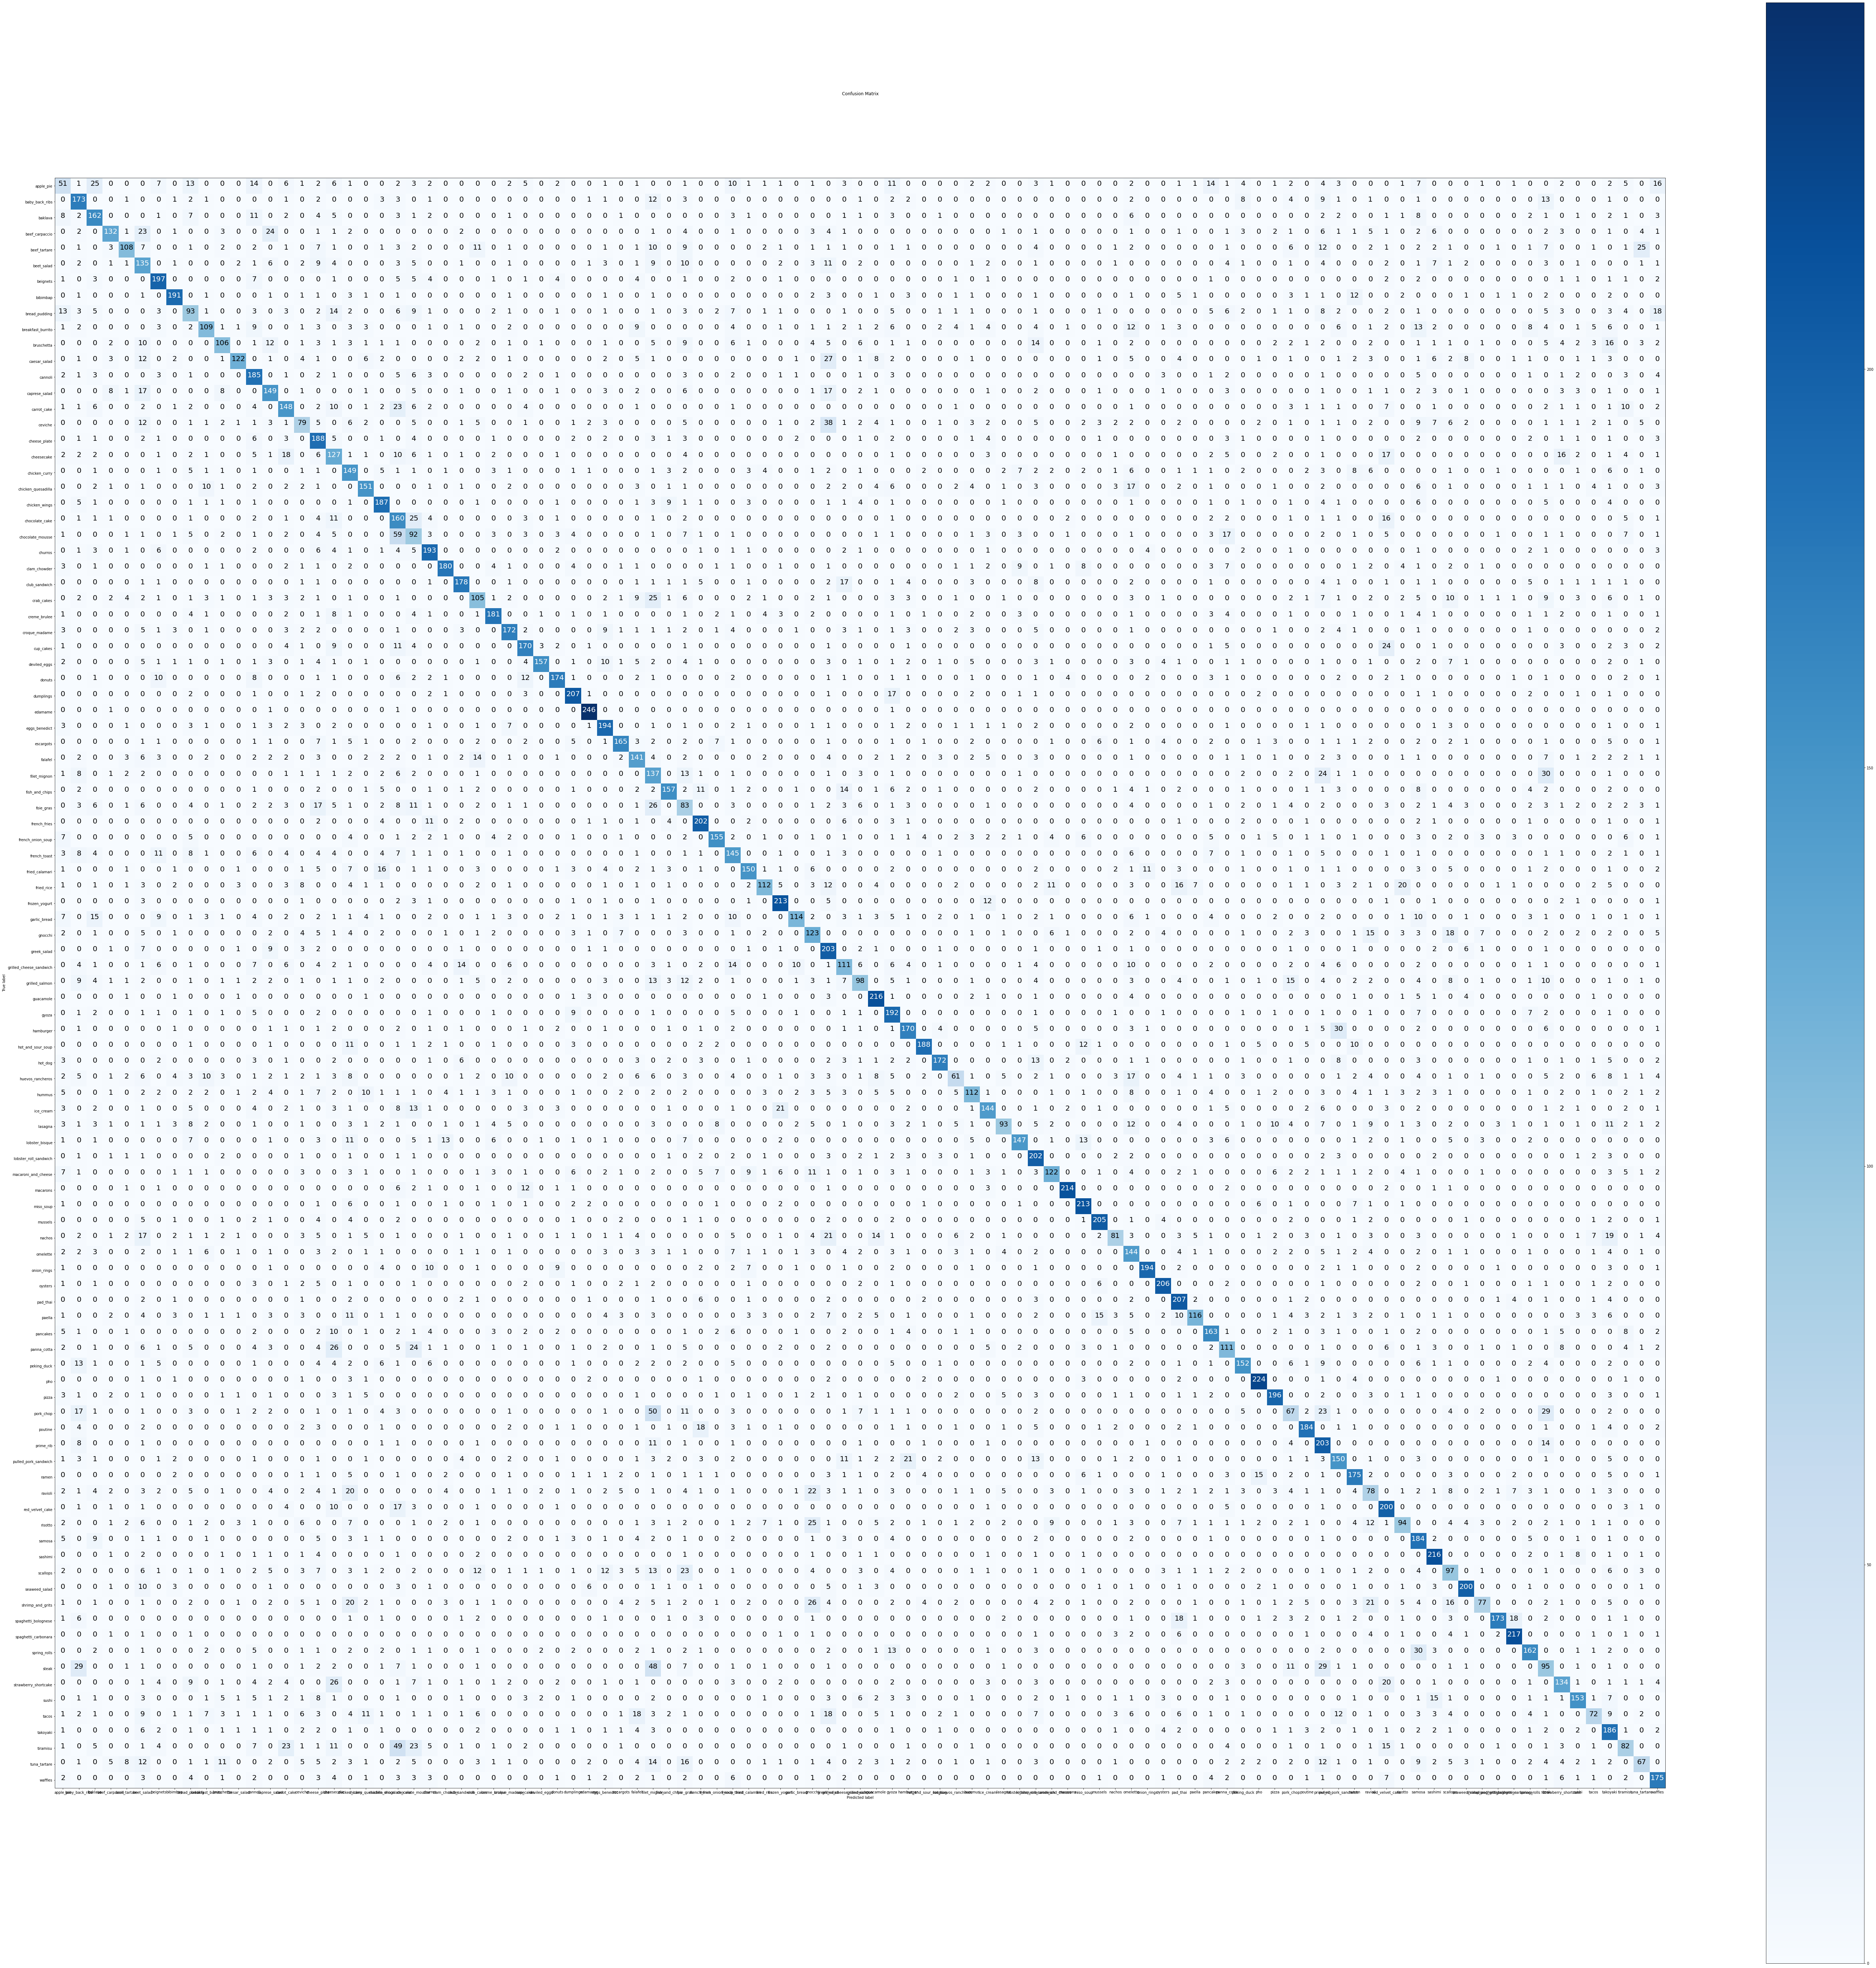

In [50]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [51]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  ### changed(plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

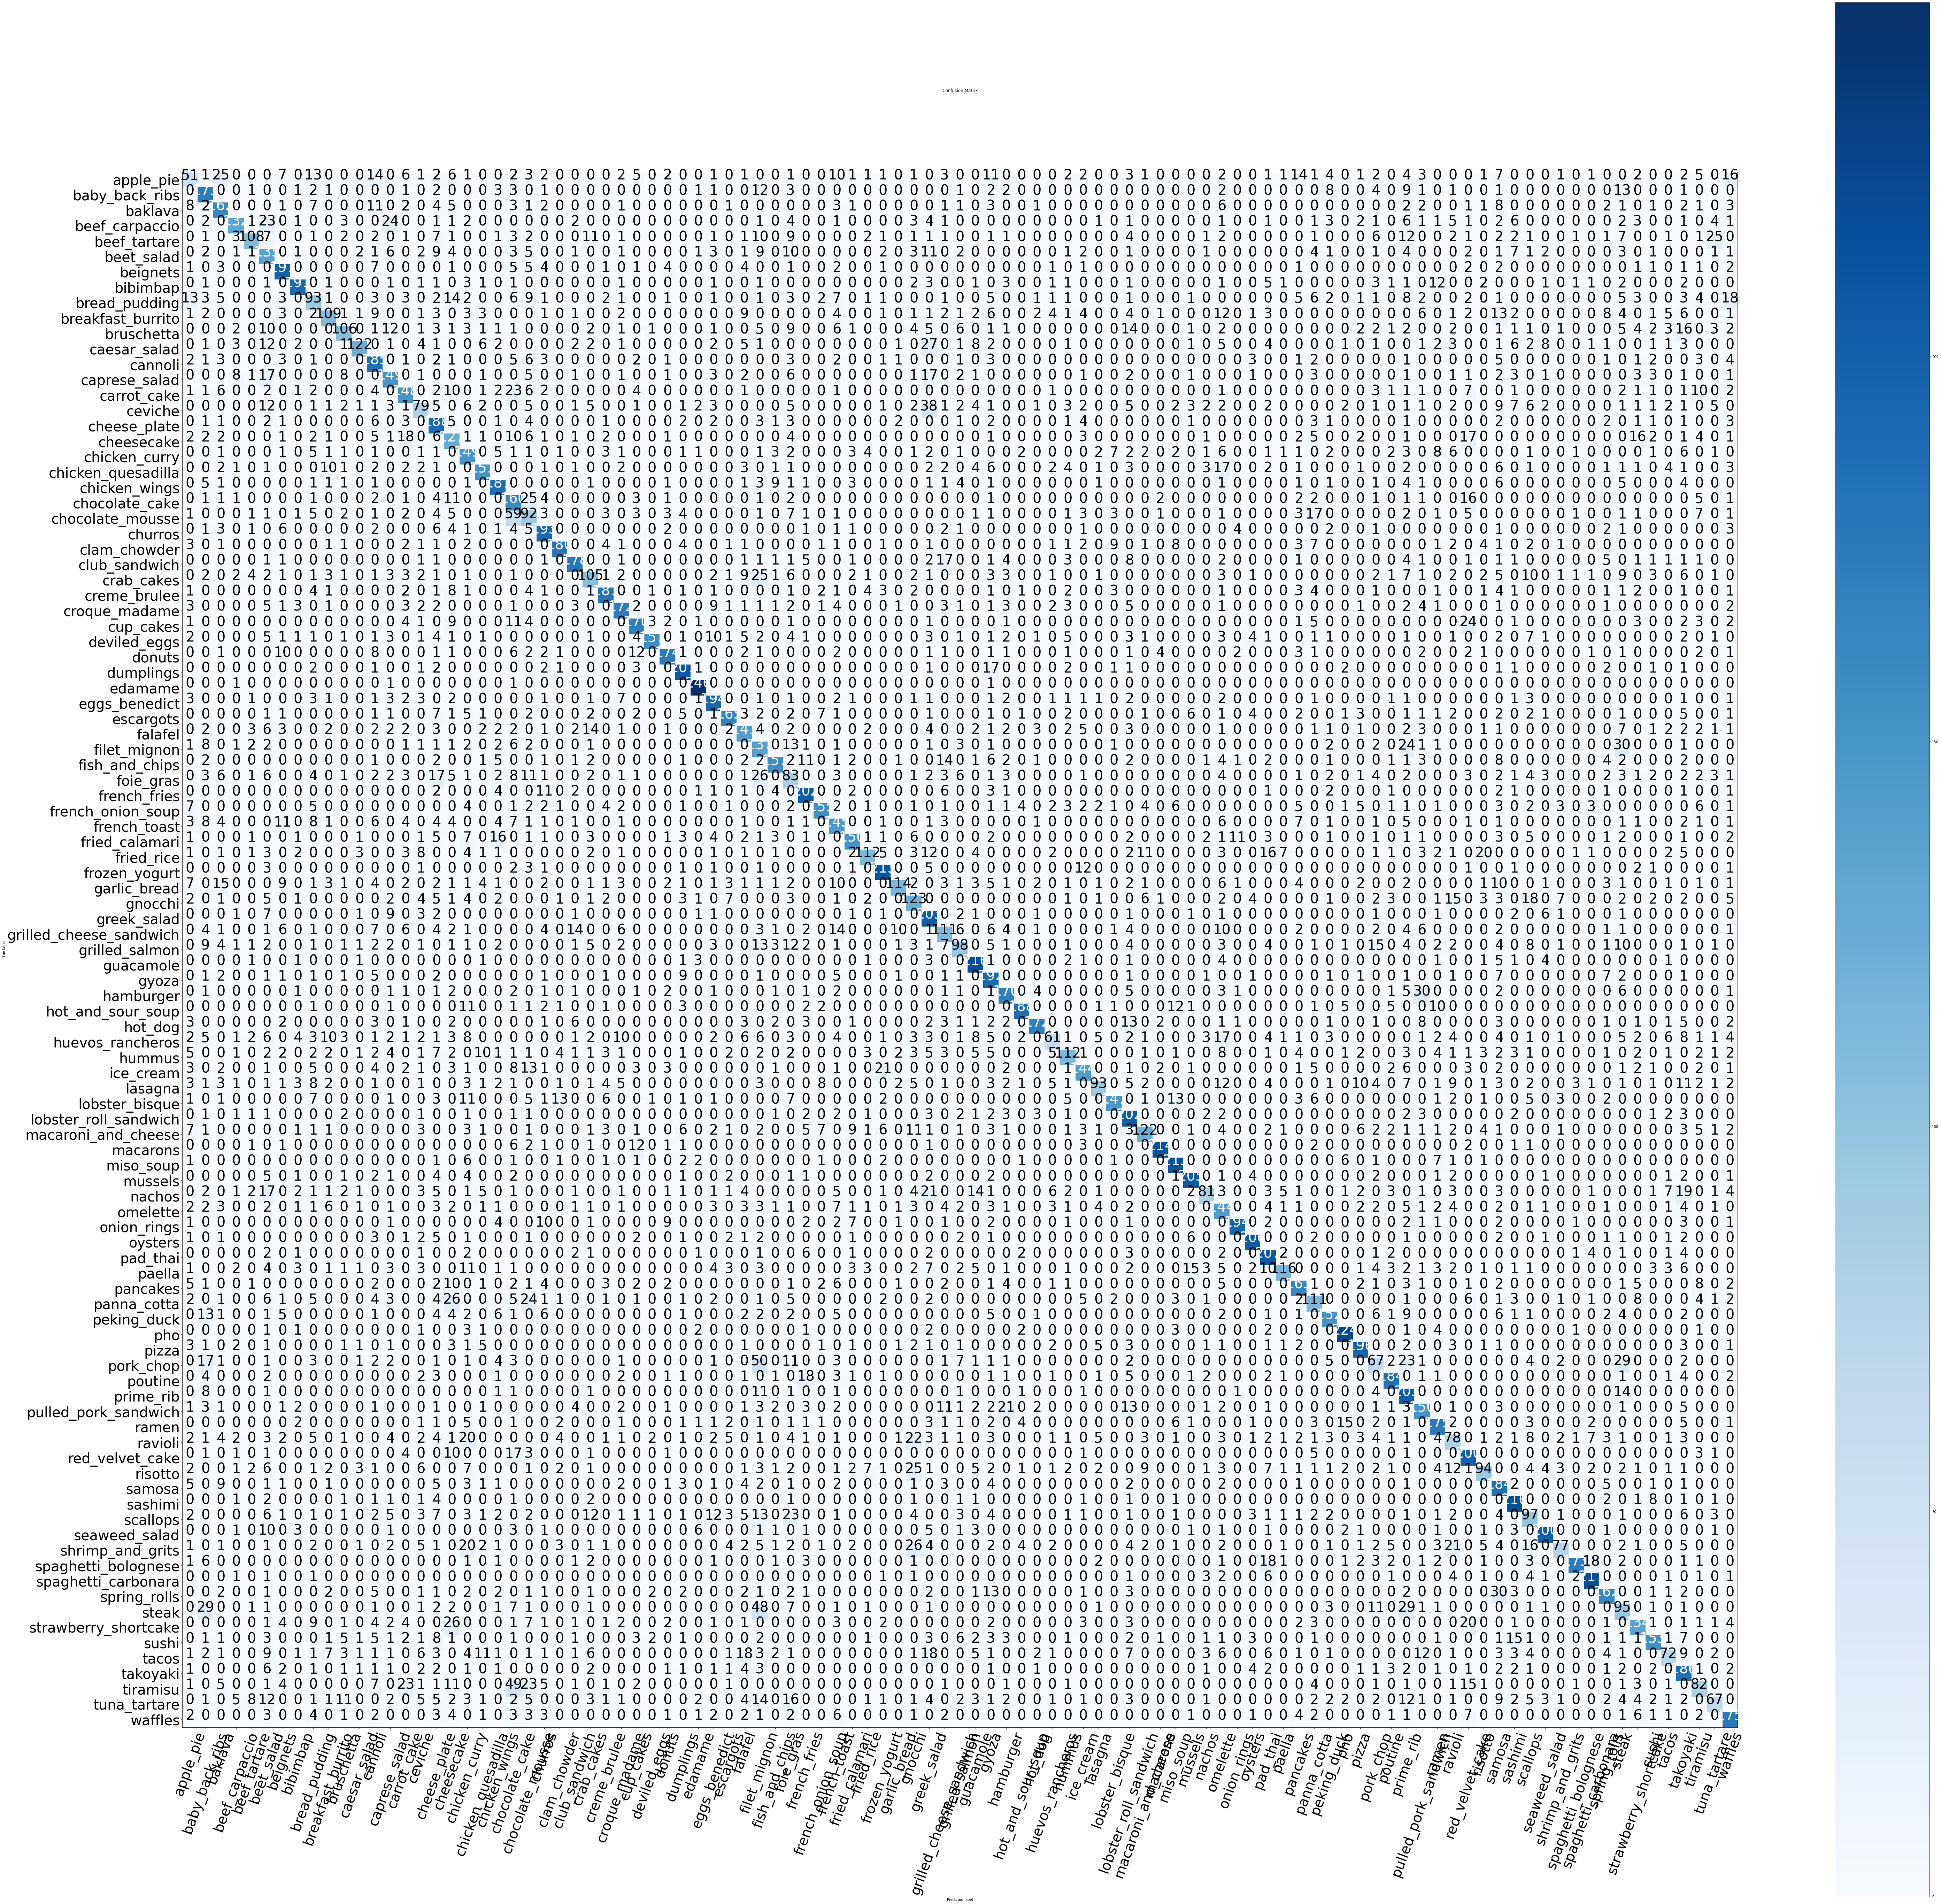

In [52]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=40,
                      savefig=True)

## Let's keep the evaluatuion train goining , time for a classification report

scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g precision, recall and F1) called classfifcation_report , let's try it out .

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's prediction but with so many classes, they're quite hard to understand.
how about we create a visualization to get a better understanding?

In [54]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

let's plot all of our classes F1-scores...

In [55]:
# create empty dictionary
class_f1_scores = {}

# loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break

  else:
    # add class names and f1-score to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [56]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores
     

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

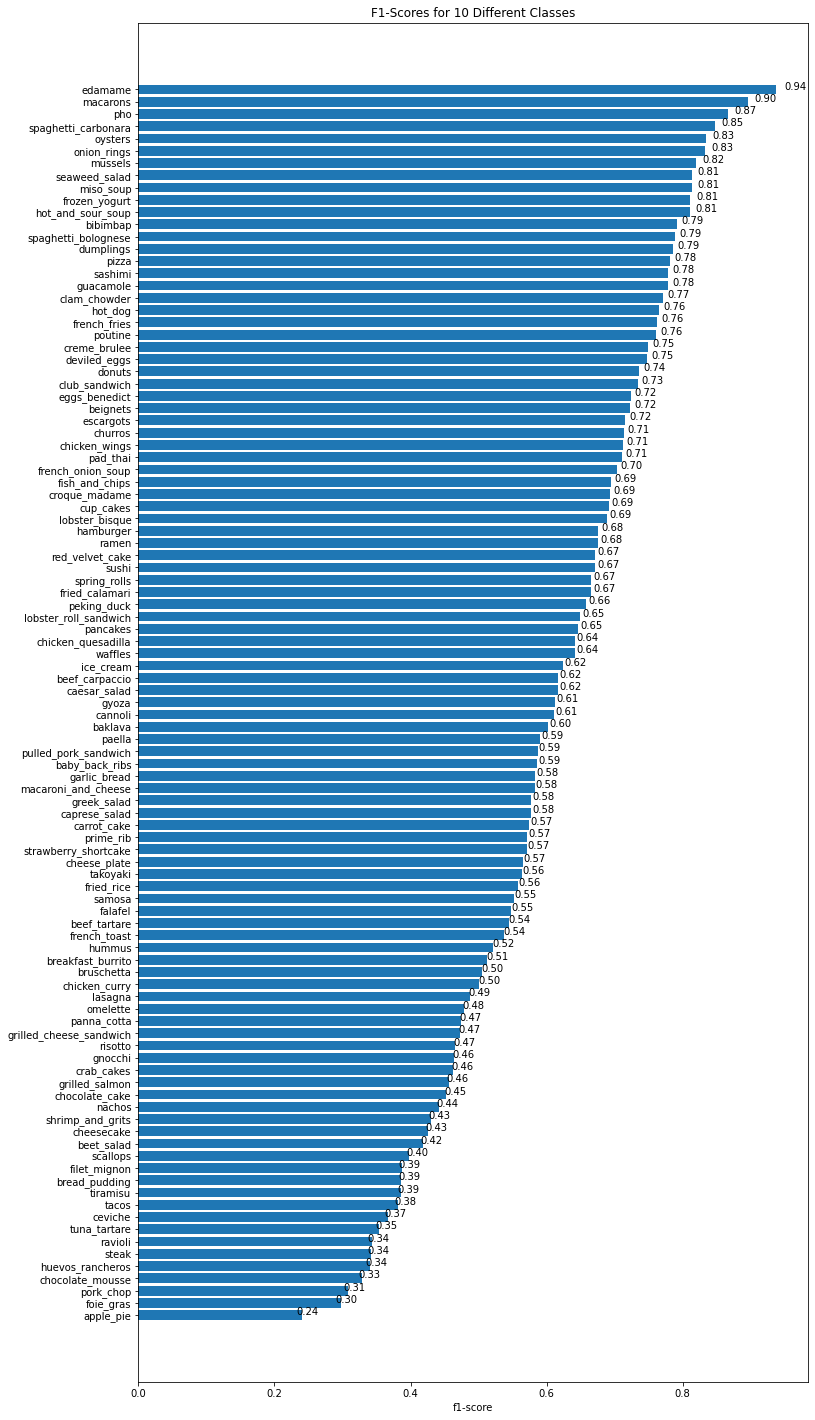

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images

now, this the real test, how does our model go on food images not even in our test dataset (images of our own,we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess image, specifically it will need to: 
* read in target image filepath using `tf.io.read_file() `
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [65]:
# create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  reads in an image from filename, tuens it into a tensor and reshape into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
   filename (str): path to target image
   image_shape (int) : hight/width dimension of target image size
   scale (bool): scale pixel values from 0-255 to 0-1 or not 
 
  return:
    image tensor of shape (img_shape, img_shape,3)
  """
    # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


Now we/ve got a function to load and prepare target images, let's now write some code to visualize images, their target label and our models predictions.

specificaally, we'll write some code to:
1. load a few random images from the test dataset 
2. make predictions on the loaded images 
3. plot the original images(s) along with the model's prediction , prediction and probability and truth label

1/1 [==============================] - 0s 29ms/step


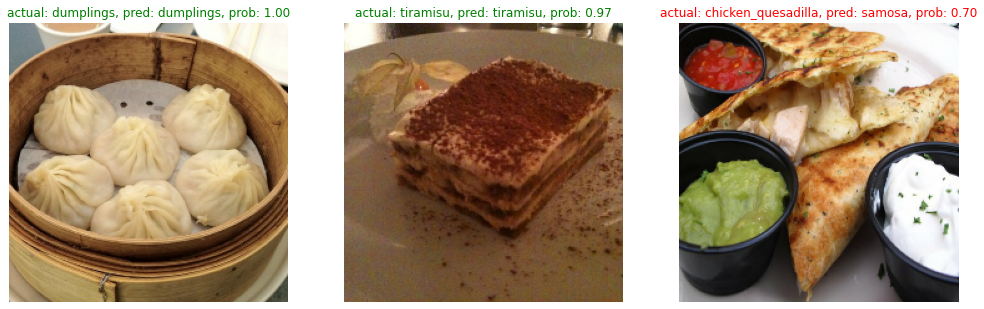

In [71]:
# make preds on a series of random images
import os 
import random 
plt.figure(figsize=(17,10))
for i in range(3):
  # choose a random images from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  #load the images and make prediction 
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model.predict(img_expanded) # get predition probabilities
  pred_class = class_names[pred_prob.argmax()] # get highset prediction 

  # plot the images 
  plt.subplot(1,3,i+1)
  plt.imshow(img/255)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
to find out where our model is most wrong, let's write some code to find out the following:

1. get all of the image file paths in the test dataset using`list_files()` method.
2. create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilies.
3. use our DataFrame to find all the wrong prediction (where the ground truth label dosent match the prediction)
4. sort the DataFrame based on wrong prediction (hav e the highest probability preciction at the top).
5. visualize the images with the highest prediction probabilities but have the wrong prediction. 

In [73]:


# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]
     


[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [76]:
# 2. create a Dataframe of different parameter for each of our test images
import  pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),# getbthe maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537900          waffles               waffles  
25248   0.501951          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [77]:
# 3. find out in our DataFrame which predictions are wrong 
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [78]:
# 4. sort our DataFrame to have most wrong prediction at the top 
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

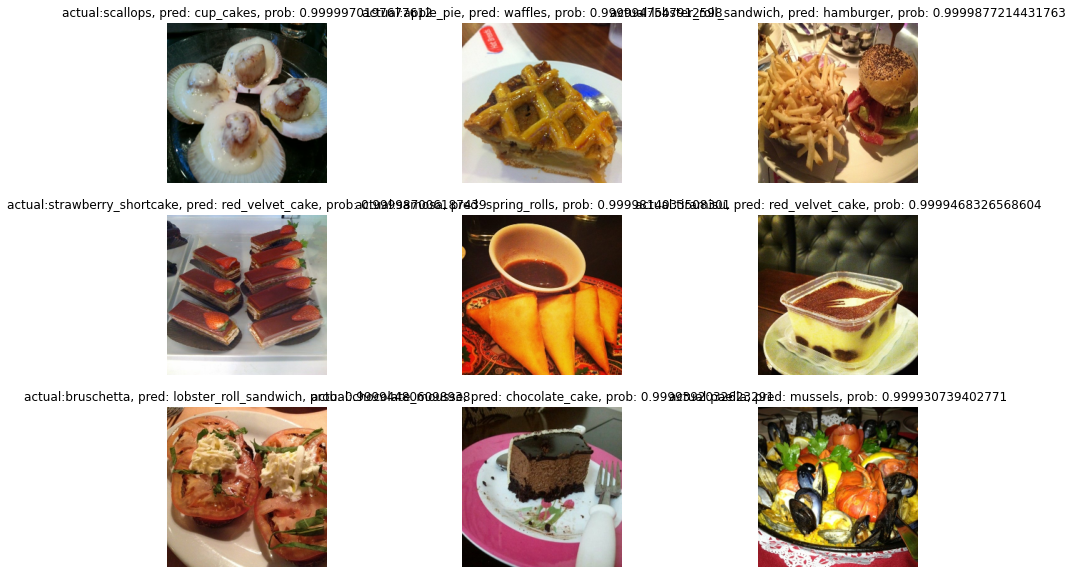

In [81]:
# 5. visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img= load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _= row #only intrested in a few parameters of each row 
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname}, pred: {y_pred_classname}, prob: {pred_prob}")
  plt.axis(False)

## Test out the big model on our own custom images

In [82]:
# Get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip") 

--2023-02-07 15:25:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.70MB/s    in 1.6s    

2023-02-07 15:25:02 (7.70 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [83]:
# ge custom food images filepaths
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 25ms/step


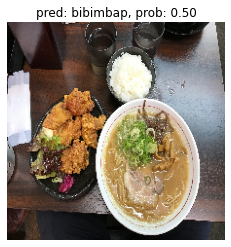

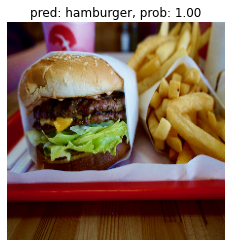

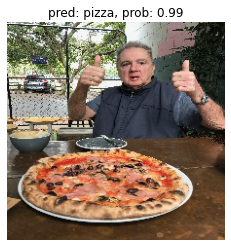

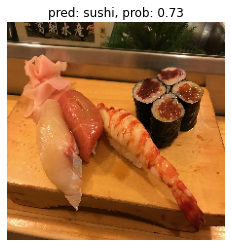

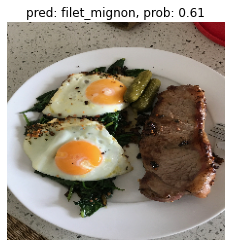

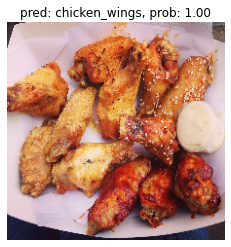

In [84]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)